In [2]:
!pip install Nasdaq-Data-Link

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, SimpleRNN, GRU
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
np.random.seed(1234)  

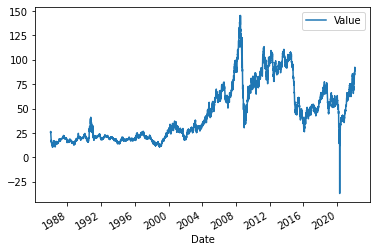

In [3]:
# WTI Crude Oil price from the US Department of Energy
mydata = nasdaqdatalink.get("EIA/PET_RWTC_D") 
mydata.plot()

In [4]:
# Убрал отрицительное значение
mydata.iloc[np.where(mydata<0)[0], :] = 9.00

In [5]:
# Убрал даты - оставил только цены
mydata.reset_index(inplace=True)
mydata = mydata["Value"]

In [6]:
# Стандартизация
data_mean = mydata.mean()
data_std = mydata.std()
mydata = (mydata - data_mean) / data_std

In [7]:
# Генерация данных
data_width = 500
label_width = 50

def window(data, data_width, label_width):
  X = []
  y = []
  for i in range(data_width, len(data)-label_width):
    X.append(data.values[i-data_width:i])
    y.append(data.values[i:i+label_width])
  return (X, y)

X, y = window(mydata, data_width, label_width)

In [8]:
# Разделение на обучение, валидацию и тест
n = len(X)
train_X = X[0:int(n*0.7)]
val_X = X[int(n*0.7):int(n*0.9)]
test_X = X[int(n*0.9):]
train_y = y[0:int(n*0.7)]
val_y = y[int(n*0.7):int(n*0.9)]
test_y = y[int(n*0.9):]

In [9]:
# Погдотовка данных для нейронной сети
train_X = np.asarray(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
val_X = np.asarray(val_X)
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
test_X = np.asarray(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
train_y = np.asarray(train_y)
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
val_y = np.asarray(val_y)
val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
test_y = np.asarray(test_y)
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

In [10]:
# Linear model

Linear_model = Sequential()
Linear_model.add(Dense(units=50, activation='sigmoid', input_shape=(train_X.shape[1], )))
Linear_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
Linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                25050     
                                                                 
Total params: 25,050
Trainable params: 25,050
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Dense model

Dense_model = Sequential()
Dense_model.add(Dense(512, activation='relu', input_shape=(train_X.shape[1], )))
Dense_model.add(Dense(50, activation='sigmoid'))

Dense_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
Dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               256512    
                                                                 
 dense_2 (Dense)             (None, 50)                25650     
                                                                 
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0
_________________________________________________________________


In [12]:
# LSTM model (easy)

eLSTM_model = Sequential()

eLSTM_model.add(LSTM(
         input_shape=(train_X.shape[1], train_X.shape[2]),
         units=32,
         return_sequences=False))

eLSTM_model.add(Dense(units=50, activation='sigmoid'))
eLSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
eLSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_3 (Dense)             (None, 50)                1650      
                                                                 
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________


In [13]:
# LSTM model (complex)

cLSTM_model = Sequential()

cLSTM_model.add(LSTM(
         input_shape=(train_X.shape[1], train_X.shape[2]),
         units=100,
         return_sequences=True))
cLSTM_model.add(Dropout(0.2))

cLSTM_model.add(LSTM(
          units=50,
          return_sequences=False))
cLSTM_model.add(Dropout(0.2))

cLSTM_model.add(Dense(units=50, activation='sigmoid'))
cLSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
cLSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
Total params: 73,550
Trainable params: 73,550
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_elstm = eLSTM_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=1, mode='min')])
history_clstm = cLSTM_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=1, mode='min')])
history_linear = Linear_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2, mode='min')])
history_dense = Dense_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2, mode='min')])

Epoch 1/20
31/31 [==============================] - 18s 492ms/step - loss: 1.3164 - mean_absolute_error: 1.0523 - val_loss: 0.7817 - val_mean_absolute_error: 0.7171
Epoch 2/20
31/31 [==============================] - 16s 516ms/step - loss: 0.9676 - mean_absolute_error: 0.8951 - val_loss: 0.7138 - val_mean_absolute_error: 0.6734
Epoch 3/20
31/31 [==============================] - 12s 393ms/step - loss: 0.7569 - mean_absolute_error: 0.7781 - val_loss: 0.6823 - val_mean_absolute_error: 0.6781
Epoch 4/20
31/31 [==============================] - 15s 486ms/step - loss: 0.6949 - mean_absolute_error: 0.7438 - val_loss: 0.6381 - val_mean_absolute_error: 0.6573
Epoch 5/20
31/31 [==============================] - 12s 378ms/step - loss: 0.6676 - mean_absolute_error: 0.7281 - val_loss: 0.6099 - val_mean_absolute_error: 0.6457
Epoch 6/20
31/31 [==============================] - 13s 411ms/step - loss: 0.6497 - mean_absolute_error: 0.7172 - val_loss: 0.5862 - val_mean_absolute_error: 0.6355
Epoch 7/20

In [15]:
pred_e = eLSTM_model.predict(test_X)
pred_c = cLSTM_model.predict(test_X)
pred_d = Dense_model.predict(test_X)
pred_l = Linear_model.predict(test_X)

27/27 [==============================] - 0s 2ms/step


In [16]:
# Форматирование предсказаний вариант 1
def transform_pred1(pred):
  pred_data = []
  for i, val in enumerate(pred):
    if i==0: 
      pred_data = val
      continue
    else: pred_data = np.append(pred_data,val[-1])
  print(len(pred_data))
  return pred_data

In [17]:
# Форматирование предсказаний вариант 2
def transform_pred2(pred):
  pred_data = []
  for i in range(len(pred)//50+1):
    pred_data.extend(pred[i*50])
  pred_data.extend(pred[-1][-len(pred)%50+1:])
  print(len(pred_data))
  return pred_data

In [18]:
transformed_preds = []
for pred in [pred_e, pred_c, pred_d, pred_l]:
  transformed_preds.append(transform_pred1(pred))

907
907
907
907


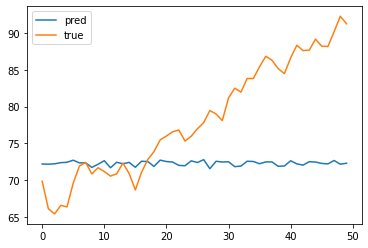

In [19]:
# Сравнение предсказаний для конкретного окна
plt.plot(pred_e[-1] * data_std + data_mean, label='pred')
plt.plot(test_y[-1] * data_std + data_mean, label='true')
plt.legend()
plt.show()

907


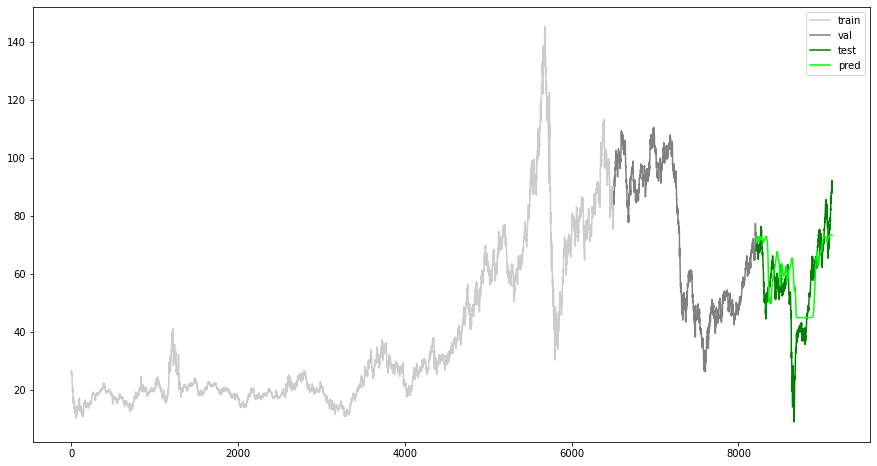

In [20]:
pred_data = transform_pred1(pred_c)
# Предсказания cLSTM 
plt.figure(figsize=(15,8))
plt.plot(mydata[:-len(pred_data)-len(val_X)] * data_std + data_mean, label="train", c='0.8')
plt.plot(mydata[-len(pred_data)-len(val_X):-len(pred_data)] * data_std + data_mean, label="val", c='gray')
plt.plot(pd.Series(mydata[-len(pred_data):] * data_std + data_mean), label="test", c='#008000')
# for pred_data in transformed_preds:
#   plt.plot((pd.Series(pred_data, [len(mydata)-len(pred_data)+i for i in range(len(pred_data))]) * data_std + data_mean))
plt.plot((pd.Series(pred_data, [len(mydata)-len(pred_data)+i for i in range(len(pred_data))]) * data_std + data_mean), label="pred", c='#00FF00')
plt.legend()
plt.show()

In [25]:
for model in [eLSTM_model, cLSTM_model, Linear_model, Dense_model]:
 model.evaluate(test_X, test_y)

27/27 [==============================] - 0s 3ms/step - loss: 0.4705 - mean_absolute_error: 0.5403
